### Load Packages

In [2]:
import gc
import os
import time
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import stats
from scipy.signal import hann
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.signal import convolve
from sklearn.svm import NuSVR, SVR
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold
warnings.filterwarnings("ignore")

### Load data

In [3]:
# Load train file
train = pd.read_csv(os.path.join('D:/NINI data/data','train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

KeyboardInterrupt: 

In [3]:
train.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [22]:
print("Train has: rows:{} cols:{}".format(train.shape[0], train.shape[1]))

Train has: rows:629145480 cols:2


In [19]:
#Load submission file
submission = pd.read_csv('D:/NINI data/data/sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [24]:
print("submission has: rows:{} cols:{}".format(submission.shape[0], submission.shape[1]))

submission has: rows:2624 cols:1


There are 2624 files in test

In [25]:
len(os.listdir(os.path.join('D:/NINI data/data', 'test')))

2624

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


### Visualization  
Let's plot 1% of the data. For this we will sample every 100 points of data.

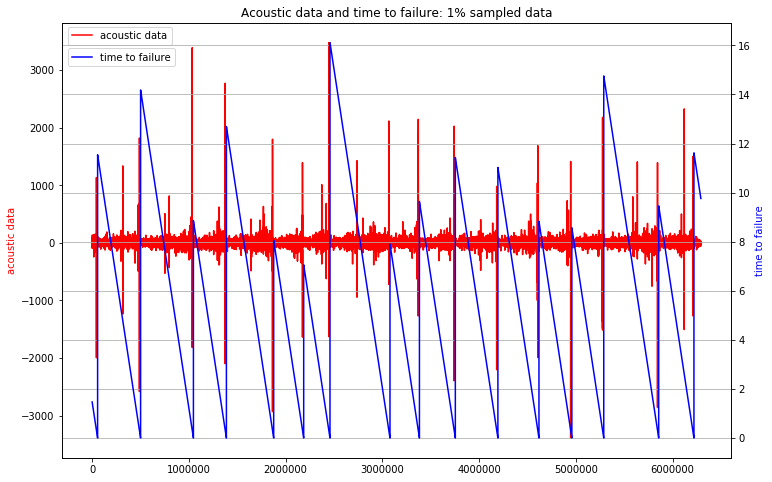

In [35]:
train_ad_sample = train['acoustic_data'].values[::100]
train_ttf_sample = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample, train_ttf_sample, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample, train_ttf_sample)
del train_ad_sample
del train_ttf_sample

The acoustic data shows complex oscilations with variable amplitude. Just before each failure there is an increase in the amplitude of the acoustic data. We see that large amplitudes are also obtained at different moments in time (for example about the mid-time between two succesive failures).  

Let's plot as well the first 1% of the data

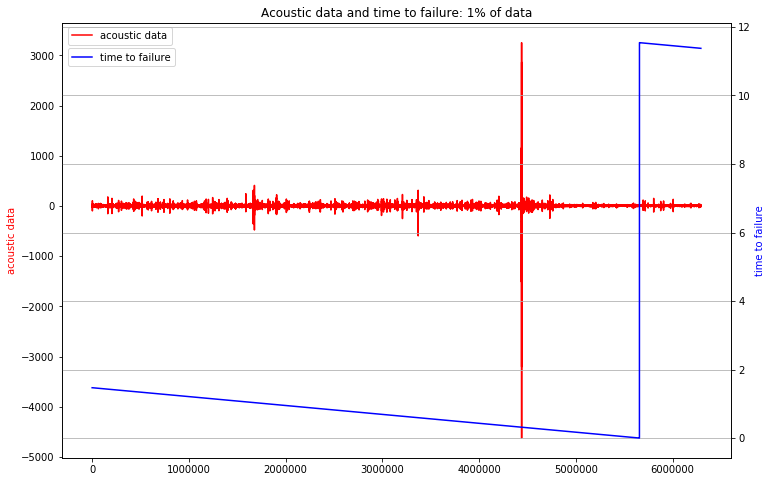

In [36]:
train_ad_sample = train['acoustic_data'].values[:6291455]
train_ttf_sample = train['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample, train_ttf_sample, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample
del train_ttf_sample

### Data preprocessing
Because we have only one feature(**acoustic_data**), and the size of the training set is very large( more that 60000000 rows), it is a good idea to reduce the size of the training set with **making new segment** and also to **increase the number of attributes by using statistical attributes.**

这里直接用王意天同学处理好的train和test数据  
以下直接复制黏贴王意天同学处理的代码，没有运行

In [40]:
rows = 150000
segments = int(np.floor(train.shape[0] / rows))
print(segments)

4194


In [41]:
X_train = pd.DataFrame(index=range(segments), dtype=np.float64) # 使用对应的特征
y_train = pd.DataFrame(index=range(segments), dtype=np.float64,
                       columns=['time_to_failure'])

Here define some functions

In [ ]:
def calc_change_rate(x):
    change = (np.diff(x) / x[:-1]).values
    change = change[np.nonzero(change)[0]]  # 因为会返回tuple，所以要加[0]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    return np.mean(change)


def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)
    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta


# y = ax + b, solve a
def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

Deal with X_train and y_train

In [ ]:
scale = 1  # test:使滑动窗口缩小10倍
for segment in range(segments):
    # y_train and X_train
    #     if segment * rows / scale + rows > train.shape[0]:
    #         break
    seg = train.iloc[int(segment * rows / scale): int(segment * rows / scale + rows)]
    x = pd.Series(seg['acoustic_data'].values)
    y = seg['time_to_failure'].values[-1]  # 只取倒数第一个值，只过了0.0375s, 如果遇到阶跃怎么办？

    y_train.loc[segment, 'time_to_failure'] = y  # y_train
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'sum'] = x.sum()
    X_train.loc[segment, 'skew'] = skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)
    X_train.loc[segment, 'mad'] = x.mad()
    X_train.loc[segment, 'med'] = x.median()

    X_train.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_train.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_train.loc[segment, 'abs_max'] = np.abs(x).max()
    X_train.loc[segment, 'abs_min'] = np.abs(x).min()

    X_train.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_train.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_train.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_train.loc[segment, 'std_last_10000'] = x[-10000:].std()

    X_train.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_train.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_train.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_train.loc[segment, 'avg_last_10000'] = x[-10000:].mean()

    X_train.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_train.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_train.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_train.loc[segment, 'min_last_10000'] = x[-10000:].min()

    X_train.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_train.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_train.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_train.loc[segment, 'max_last_10000'] = x[-10000:].max()

    X_train.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_train.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_train.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])

    X_train.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_train.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_train.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_train.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])

    X_train.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_train.loc[segment, 'q01'] = np.quantile(x, 0.01)

    X_train.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_train.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_train.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_train.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

    X_train.loc[segment, 'trend'] = add_trend_feature(x)
    X_train.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_train.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x).std()

    # signal processing
    X_train.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_train.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_train.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_train.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_train.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_train.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_train.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_train.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_train.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_train.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_train.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_train.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_train.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_train.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_train.loc[segment, 'MA_700MA_BB_high_mean'] = (
                X_train.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_train.loc[
            segment, 'MA_700MA_std_mean']).mean()
    X_train.loc[segment, 'MA_700MA_BB_low_mean'] = (
                X_train.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_train.loc[
            segment, 'MA_700MA_std_mean']).mean()
    X_train.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_train.loc[segment, 'MA_400MA_BB_high_mean'] = (
                X_train.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_train.loc[
            segment, 'MA_400MA_std_mean']).mean()
    X_train.loc[segment, 'MA_400MA_BB_low_mean'] = (
                X_train.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_train.loc[
            segment, 'MA_400MA_std_mean']).mean()
    X_train.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_train.drop('Moving_average_700_mean', axis=1, inplace=True)

    X_train.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_train.loc[segment, 'q999'] = np.quantile(x, 0.999)
    X_train.loc[segment, 'q001'] = np.quantile(x, 0.001)
    X_train.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values

        X_train.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_train.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_train.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X_train.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_train.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_train.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_train.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

Deal with test set

In [ ]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)
for seg_id in X_test.index:
    # X_test
    seg = pd.read_csv('./test/' + seg_id + '.csv')
    segment = seg_id
    x = pd.Series(seg['acoustic_data'].values)

    X_test.loc[segment, 'ave'] = x.mean()
    X_test.loc[segment, 'std'] = x.std()
    X_test.loc[segment, 'max'] = x.max()
    X_test.loc[segment, 'min'] = x.min()
    X_test.loc[segment, 'sum'] = x.sum()
    X_test.loc[segment, 'skew'] = skew(x)
    X_test.loc[segment, 'kurt'] = kurtosis(x)
    X_test.loc[segment, 'mad'] = x.mad()
    X_test.loc[segment, 'med'] = x.median()

    X_test.loc[segment, 'mean_change_abs'] = np.mean(np.diff(x))
    X_test.loc[segment, 'mean_change_rate'] = calc_change_rate(x)
    X_test.loc[segment, 'abs_max'] = np.abs(x).max()
    X_test.loc[segment, 'abs_min'] = np.abs(x).min()

    X_test.loc[segment, 'std_first_50000'] = x[:50000].std()
    X_test.loc[segment, 'std_last_50000'] = x[-50000:].std()
    X_test.loc[segment, 'std_first_10000'] = x[:10000].std()
    X_test.loc[segment, 'std_last_10000'] = x[-10000:].std()

    X_test.loc[segment, 'avg_first_50000'] = x[:50000].mean()
    X_test.loc[segment, 'avg_last_50000'] = x[-50000:].mean()
    X_test.loc[segment, 'avg_first_10000'] = x[:10000].mean()
    X_test.loc[segment, 'avg_last_10000'] = x[-10000:].mean()

    X_test.loc[segment, 'min_first_50000'] = x[:50000].min()
    X_test.loc[segment, 'min_last_50000'] = x[-50000:].min()
    X_test.loc[segment, 'min_first_10000'] = x[:10000].min()
    X_test.loc[segment, 'min_last_10000'] = x[-10000:].min()

    X_test.loc[segment, 'max_first_50000'] = x[:50000].max()
    X_test.loc[segment, 'max_last_50000'] = x[-50000:].max()
    X_test.loc[segment, 'max_first_10000'] = x[:10000].max()
    X_test.loc[segment, 'max_last_10000'] = x[-10000:].max()

    X_test.loc[segment, 'max_to_min'] = x.max() / np.abs(x.min())
    X_test.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
    X_test.loc[segment, 'count_big'] = len(x[np.abs(x) > 500])

    X_test.loc[segment, 'mean_change_rate_first_50000'] = calc_change_rate(x[:50000])
    X_test.loc[segment, 'mean_change_rate_last_50000'] = calc_change_rate(x[-50000:])
    X_test.loc[segment, 'mean_change_rate_first_10000'] = calc_change_rate(x[:10000])
    X_test.loc[segment, 'mean_change_rate_last_10000'] = calc_change_rate(x[-10000:])

    X_test.loc[segment, 'q95'] = np.quantile(x, 0.95)
    X_test.loc[segment, 'q99'] = np.quantile(x, 0.99)
    X_test.loc[segment, 'q05'] = np.quantile(x, 0.05)
    X_test.loc[segment, 'q01'] = np.quantile(x, 0.01)

    X_test.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
    X_test.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
    X_test.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
    X_test.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

    X_test.loc[segment, 'trend'] = add_trend_feature(x)
    X_test.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
    X_test.loc[segment, 'abs_mean'] = np.abs(x).mean()
    X_test.loc[segment, 'abs_std'] = np.abs(x).std()

    # signal processing
    X_test.loc[segment, 'Hilbert_mean'] = np.abs(hilbert(x)).mean()
    X_test.loc[segment, 'Hann_window_mean'] = (convolve(x, hann(150), mode='same') / sum(hann(150))).mean()
    X_test.loc[segment, 'classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
    X_test.loc[segment, 'classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
    X_test.loc[segment, 'classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
    X_test.loc[segment, 'classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
    X_test.loc[segment, 'classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
    X_test.loc[segment, 'classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
    X_test.loc[segment, 'classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
    X_test.loc[segment, 'classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
    X_test.loc[segment, 'Moving_average_700_mean'] = x.rolling(window=700).mean().mean(skipna=True)
    ewma = pd.Series.ewm
    X_test.loc[segment, 'exp_Moving_average_300_mean'] = (ewma(x, span=300).mean()).mean(skipna=True)
    X_test.loc[segment, 'exp_Moving_average_3000_mean'] = ewma(x, span=3000).mean().mean(skipna=True)
    X_test.loc[segment, 'exp_Moving_average_30000_mean'] = ewma(x, span=30000).mean().mean(skipna=True)
    no_of_std = 3
    X_test.loc[segment, 'MA_700MA_std_mean'] = x.rolling(window=700).std().mean()
    X_test.loc[segment, 'MA_700MA_BB_high_mean'] = (
                X_test.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_test.loc[
            segment, 'MA_700MA_std_mean']).mean()
    X_test.loc[segment, 'MA_700MA_BB_low_mean'] = (
                X_test.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_test.loc[
            segment, 'MA_700MA_std_mean']).mean()
    X_test.loc[segment, 'MA_400MA_std_mean'] = x.rolling(window=400).std().mean()
    X_test.loc[segment, 'MA_400MA_BB_high_mean'] = (
                X_test.loc[segment, 'Moving_average_700_mean'] + no_of_std * X_test.loc[
            segment, 'MA_400MA_std_mean']).mean()
    X_test.loc[segment, 'MA_400MA_BB_low_mean'] = (
                X_test.loc[segment, 'Moving_average_700_mean'] - no_of_std * X_test.loc[
            segment, 'MA_400MA_std_mean']).mean()
    X_test.loc[segment, 'MA_1000MA_std_mean'] = x.rolling(window=1000).std().mean()
    X_test.drop('Moving_average_700_mean', axis=1, inplace=True)

    X_test.loc[segment, 'iqr'] = np.subtract(*np.percentile(x, [75, 25]))
    X_test.loc[segment, 'q999'] = np.quantile(x, 0.999)
    X_test.loc[segment, 'q001'] = np.quantile(x, 0.001)
    X_test.loc[segment, 'ave10'] = stats.trim_mean(x, 0.1)

    for windows in [10, 100, 1000]:
        x_roll_std = x.rolling(windows).std().dropna().values
        x_roll_mean = x.rolling(windows).mean().dropna().values

        X_test.loc[segment, 'ave_roll_std_' + str(windows)] = x_roll_std.mean()
        X_test.loc[segment, 'std_roll_std_' + str(windows)] = x_roll_std.std()
        X_test.loc[segment, 'max_roll_std_' + str(windows)] = x_roll_std.max()
        X_test.loc[segment, 'min_roll_std_' + str(windows)] = x_roll_std.min()
        X_test.loc[segment, 'q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[segment, 'q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[segment, 'q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[segment, 'q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[segment, 'av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
        X_test.loc[segment, 'av_change_rate_roll_std_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
        X_test.loc[segment, 'abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

        X_test.loc[segment, 'ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
        X_test.loc[segment, 'std_roll_mean_' + str(windows)] = x_roll_mean.std()
        X_test.loc[segment, 'max_roll_mean_' + str(windows)] = x_roll_mean.max()
        X_test.loc[segment, 'min_roll_mean_' + str(windows)] = x_roll_mean.min()
        X_test.loc[segment, 'q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[segment, 'q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[segment, 'q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[segment, 'q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[segment, 'av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
        X_test.loc[segment, 'av_change_rate_roll_mean_' + str(windows)] = np.mean(
            np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
        X_test.loc[segment, 'abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


#### StandardScaler

In [70]:
X_train =  pd.read_csv('D:/NINI data/X_train_138features_filtered.csv',index_col=0)
X_test = pd.read_csv('D:/NINI data/X_test_138features_filtered.csv',index_col=0)

In [56]:
for segment in range(segments):
    seg = train.iloc[segment*rows:segment*rows+rows]
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y

In [74]:
X = X_train.copy()
y = y_train.copy()
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [75]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [51]:
X_train.shape

(4194, 139)

In [52]:
X_test.shape

(2624, 139)

In [77]:
X_train_scaled.head()

,ave,std,max,min,sum,skew,kurt,mad,med,mean_change_abs,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,1.424140,-0.170214,-0.218194,0.193218,1.424140,-0.313703,-0.491310,-0.135555,0.947037,-1.326420,...,0.268470,-0.004742,0.178278,0.287332,0.965402,1.509153,0.885262,-0.631300,-1.832422,-0.004742
1,0.805716,0.004734,0.063936,-0.018037,0.805716,0.553891,0.431696,0.056233,0.947037,0.002747,...,-0.141264,0.007341,-0.025387,0.622391,0.842747,0.522428,0.294357,-0.912054,-0.890022,0.007341
2,1.511155,0.049252,-0.086289,0.163039,1.511155,0.191534,-0.492831,0.287014,0.947037,-0.218781,...,0.085078,0.099556,0.245184,0.634878,1.207106,1.530919,0.889790,0.441128,0.639209,0.099556
3,1.494934,0.043950,0.122560,-0.187796,1.494934,1.321245,0.683938,0.101152,0.947037,0.002747,...,0.083085,0.068076,0.105059,0.770151,1.160208,1.432972,0.815078,-0.949994,-1.097513,0.068076
4,1.520242,0.088495,-0.067969,0.087590,1.520242,-0.128324,-0.217434,0.211533,0.947037,-0.108017,...,-0.164151,0.138032,0.187535,1.040695,1.557034,1.393068,0.901110,0.595416,-0.465464,0.138032


In [72]:
y_train.shape

(4194, 1)

In [78]:
X_test_scaled.head()

,ave,std,max,min,sum,skew,kurt,mad,med,mean_change_abs,...,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000
0,-0.108121,-0.194605,-0.177889,0.279984,-0.108121,0.422790,-0.559723,-0.144734,-1.055925,0.445802,...,-0.139320,-0.047351,0.126941,-0.093512,-0.044701,-0.199479,-0.210516,0.681413,0.563673,-0.047351
1,-1.360332,-0.073582,-0.042321,0.034777,-1.360332,0.355412,-0.171479,-0.033272,-1.055925,-0.218781,...,-0.145565,-0.201890,-0.054843,-0.603385,-1.159422,-1.382099,-0.801422,-0.062205,-1.006714,-0.201890
2,0.354604,0.046852,0.309425,-0.165162,0.354604,0.633673,1.330083,-0.013053,0.947037,-0.329545,...,-0.041383,0.187637,0.030158,0.164546,0.373771,0.159661,-0.024868,0.041497,-0.989262,0.187637
3,0.046902,-0.286275,-0.287810,0.212080,0.046902,-0.133852,-0.383841,-0.496368,0.947037,0.778094,...,-0.183932,-0.062932,0.175332,0.204088,0.261938,-0.039861,-0.095052,1.480675,-0.454782,-0.062932
4,-1.527540,-0.088361,0.049280,0.008370,-1.527540,-0.108723,0.159190,-0.122937,-1.055925,-0.108017,...,0.129890,-0.196166,-0.048531,-0.832307,-1.621183,-1.276896,-0.504837,-1.096694,0.312498,-0.196166


In [94]:
X_test_scaled.shape

(2624, 138)

### Building models

In [82]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = X_train_scaled.columns.values

### lightLGB

#### define the model parameters

In [81]:
params = {'num_leaves': 51,
         'min_data_in_leaf': 10, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.001,
         "boosting": "gbdt",
         "feature_fraction": 0.91,
         "bagging_freq": 1,
         "bagging_fraction": 0.91,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": -1,
         "random_state": 42}

In [ ]:
oof = np.zeros(len(X_train_scaled))
predictions = np.zeros(len(X_test_scaled))
feature_importance_df = pd.DataFrame()
#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled,y_train.values)):
    strLog = "fold {}".format(fold_)
    print(strLog)
    
    X_tr, X_val = X_train_scaled.iloc[trn_idx], X_train_scaled.iloc[val_idx]
    y_tr, y_val = y_train.iloc[trn_idx], y_train.iloc[val_idx]

    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_tr, y_tr, 
                    eval_set=[(X_tr, y_tr), (X_val, y_val)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = model.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits

### CNN

In [4]:
X_train = train['acoustic_data']
y_train = train['time_to_failure']

In [5]:
# Cut training data
rows = 150_000
X_train = X_train[:int(np.floor(X_train.shape[0] / rows))*rows] #保证有整数个segments
y_train = y_train[:int(np.floor(y_train.shape[0] / rows))*rows]
X_train= X_train.values.reshape((-1, rows, 1))
print(X_train.shape)

(4194, 150000, 1)


In [6]:
y_train = y_train[rows-1::rows].values
print(y_train.shape)

(4194,)


#### Training/ Vaidation Split

In [7]:
rows = 150_000

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                y_train,
                                 
                                                test_size= 0.2,
                                                random_state= 11)

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout
from keras.optimizers import adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import TensorBoard

In [10]:
model = Sequential()

In [11]:
# Conv 1
model.add(Conv1D(32, 10, activation='relu', input_shape=(rows, 1)))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
# Max Pooling
model.add(MaxPooling1D(100))

In [13]:
# Conv 3
model.add(Conv1D(64, 10, activation='relu'))

In [14]:
# Average Pooling
model.add(GlobalAveragePooling1D())

In [15]:
model.add(Dense(16, kernel_initializer='normal',activation='relu'))

In [16]:
# Output Layer
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [17]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=0,
                              mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5',
                           save_best_only=True,
                           monitor='val_loss',
                           mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1,
                                   patience=5,
                                   verbose=1,
                                   epsilon=1e-4,
                                   mode='min')

In [18]:
model.compile(loss='mean_absolute_error', optimizer= adam(lr=1e-4), metrics=['mean_absolute_error'])

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 149991, 32)        352       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1499, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1490, 64)          20544     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 21,953
Trainable params: 21,953
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, 
        y_train,
        batch_size= 16,
        epochs= 100, 
        validation_data= (X_val, y_val),
        callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
        verbose= 0
         )

Instructions for updating:
Use tf.cast instead.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00078: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00083: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


In [21]:
y_pred = model.predict(X_val)

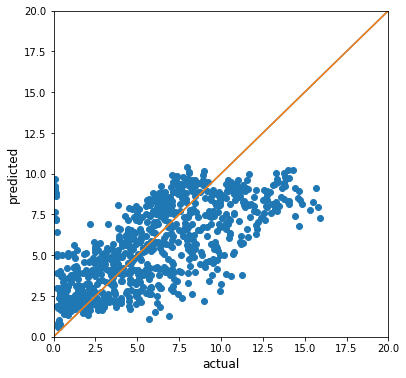

In [22]:
# Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
plt.show()

In [23]:
# training Score
score = mean_absolute_error(y_val.flatten(), y_pred)
print(f'Score: {score:0.3f}')

Score: 2.144


### Submission

In [24]:
# Submission
submission = pd.read_csv('D:/NINI data/data/sample_submission.csv', index_col='seg_id')

In [28]:
X_test = []

for segment in tqdm(submission.index):
        seg = pd.read_csv('D:/NINI data/data/test/' + segment + '.csv')
        x = pd.Series(seg['acoustic_data'].values)
        X_test.append(x)

100%|██████████████████████████████████████████████████████████████████████████████| 2624/2624 [01:48<00:00, 24.23it/s]


In [30]:
X_test = np.asarray(X_test)
X_test = X_test.reshape((-1, 1))

In [31]:
X_test.shape

(393600000, 1)

In [32]:
X_test = X_test[:int(np.floor(X_test.shape[0] / rows))*rows]
X_test= X_test.reshape((-1, rows, 1))
print(X_test.shape)

(2624, 150000, 1)


In [33]:
submission['time_to_failure'] = model.predict(X_test)

In [36]:
submission.to_csv('D:/NINI data/submission.csv')

In [37]:
submission.shape

(2624, 1)